# Viral Tweets Prediction Challenge
The goal of this competition is to develop a machine learning model to predict the virality level of each tweet based on attributes such as tweet content, media attached to the tweet, and date/time published.

## Import libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Model building
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import random
import timeit
import math 
import collections 

## Load Data

In [4]:
# Local storage path
tweets_path = "Dataset/Tweets/"
users_path = "Dataset/Users/"

# Training datasets
train_tweets = pd.read_csv(tweets_path + 'train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(tweets_path + 'train_tweets_vectorized_media.csv')
train_tweets_vectorized_text = pd.read_csv(tweets_path + 'train_tweets_vectorized_text.csv')

# Test dataset
test_tweets = pd.read_csv(tweets_path + 'test_tweets.csv')
test_tweets_vectorized_media = pd.read_csv(tweets_path + 'test_tweets_vectorized_media.csv')
test_tweets_vectorized_text = pd.read_csv(tweets_path + 'test_tweets_vectorized_text.csv')

# User dataset
users = pd.read_csv(users_path + 'users.csv')
user_vectorized_descriptions = pd.read_csv(users_path + 'user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(users_path + 'user_vectorized_profile_images.csv')

## Dimensions of Data

In [5]:
# print dimensions of data
print('Dimensions:')
print('Train tweets:', train_tweets.shape)
print('Train tweets vectorized media:', train_tweets_vectorized_media.shape)
print('Train tweets vectorized text:', train_tweets_vectorized_text.shape)
print()

print('Test tweets:', test_tweets.shape)
print('Test tweets vectorized media:', test_tweets_vectorized_media.shape)
print('Test tweets vectorized text:', test_tweets_vectorized_text.shape)
print()

print('Users:', users.shape)
print('User vectorized descriptions:', user_vectorized_descriptions.shape)
print('User vectorized profile images:', user_vectorized_profile_images.shape)

Dimensions:
Train tweets: (29625, 14)
Train tweets vectorized media: (21010, 2050)
Train tweets vectorized text: (29625, 769)

Test tweets: (12697, 13)
Test tweets vectorized media: (8946, 2050)
Test tweets vectorized text: (12697, 769)

Users: (52, 11)
User vectorized descriptions: (52, 769)
User vectorized profile images: (52, 2049)


# Exploratory Data Analysis

## Train Tweets

In [6]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [7]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

### Tweet Creation Date
tweet_created_at_year  
tweet_created_at_day  
tweet_created_at_month  
tweet_created_at_hour

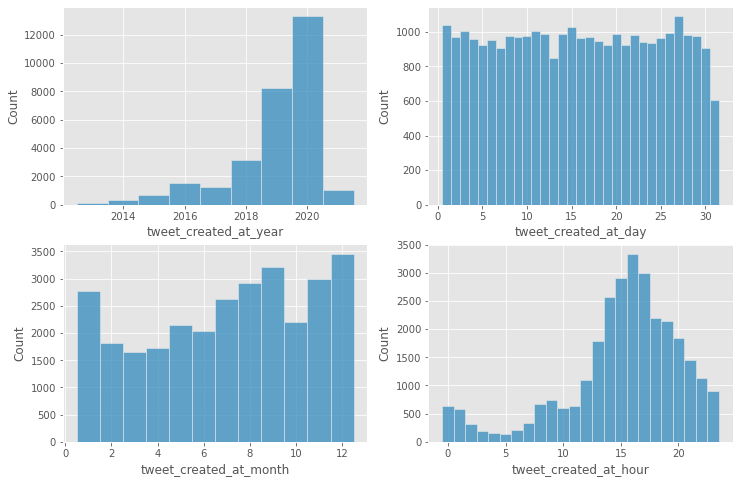

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(train_tweets, x = 'tweet_created_at_year', discrete = True, ax = axs[0,0])
sns.histplot(train_tweets, x = 'tweet_created_at_day', discrete = True, ax = axs[0,1])
sns.histplot(train_tweets, x = 'tweet_created_at_month', discrete = True, ax = axs[1,0])
sns.histplot(train_tweets, x = 'tweet_created_at_hour', discrete = True, ax = axs[1,1])
plt.show()

### Tweet Message Content
tweet_hashtag_count  
tweet_url_count  
tweet_mention_count

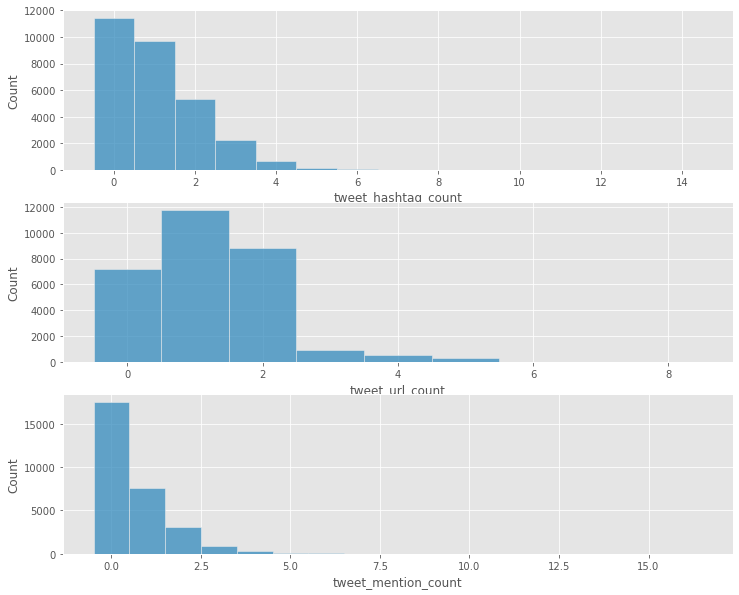

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.histplot(x = 'tweet_hashtag_count', data = train_tweets, discrete = True, ax = axs[0])
sns.histplot(x = 'tweet_url_count', data = train_tweets, discrete = True, ax = axs[1])
sns.histplot(x = 'tweet_mention_count', data = train_tweets, discrete = True, ax = axs[2])
plt.show()

### Tweet Attatchment
tweet_has_attachment   
tweet_attachment_class

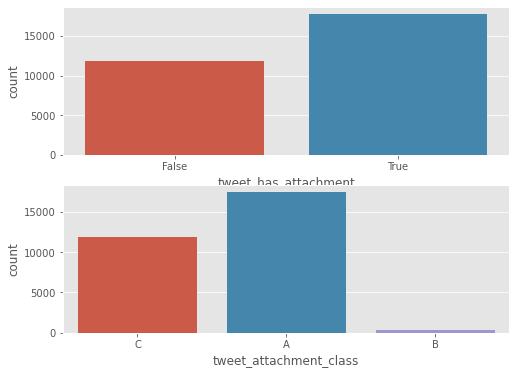

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

sns.countplot(x = 'tweet_has_attachment', data = train_tweets, ax = axs[0])
sns.countplot(x = 'tweet_attachment_class', data = train_tweets, ax = axs[1])
plt.show()

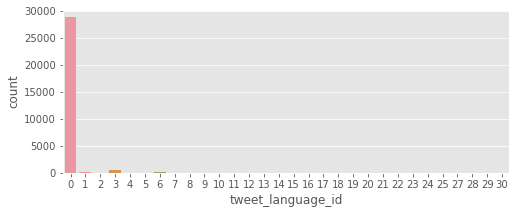

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))
sns.countplot(x = 'tweet_language_id', data = train_tweets, ax = axs)
plt.show()

### Tweet Virality

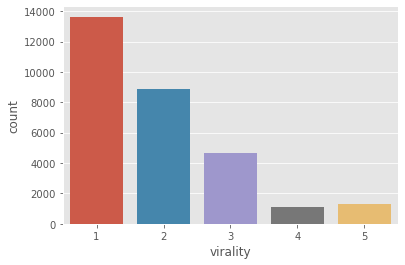

In [12]:
sns.countplot(x = 'virality', data = train_tweets)
plt.show()

### Correlation Matrix

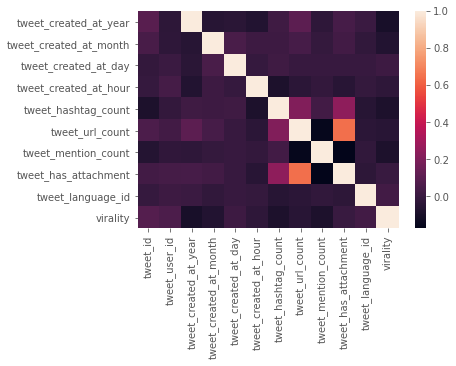

In [13]:
corrmat = train_tweets.corr()[2:] 
sns.heatmap(corrmat, square=True);

In [14]:
df_corr = train_tweets.corr()['virality'][2:-1]
top_features = df_corr.sort_values(ascending=False, key=abs)
top_features

tweet_created_at_year    -0.096487
tweet_hashtag_count      -0.083262
tweet_mention_count      -0.081958
tweet_created_at_month   -0.063757
tweet_url_count          -0.047833
tweet_language_id         0.030416
tweet_created_at_hour    -0.028583
tweet_created_at_day      0.017518
tweet_has_attachment      0.005401
Name: virality, dtype: float64

## Train Tweets Vecotrized Media

In [15]:
train_tweets_vectorized_media.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


## Train Tweets Vectorized Text

In [17]:
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


## Users

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


### User Count
user_like_count  
user_followers_count  
user_following_count  
user_listed_on_count  
user_tweet_count

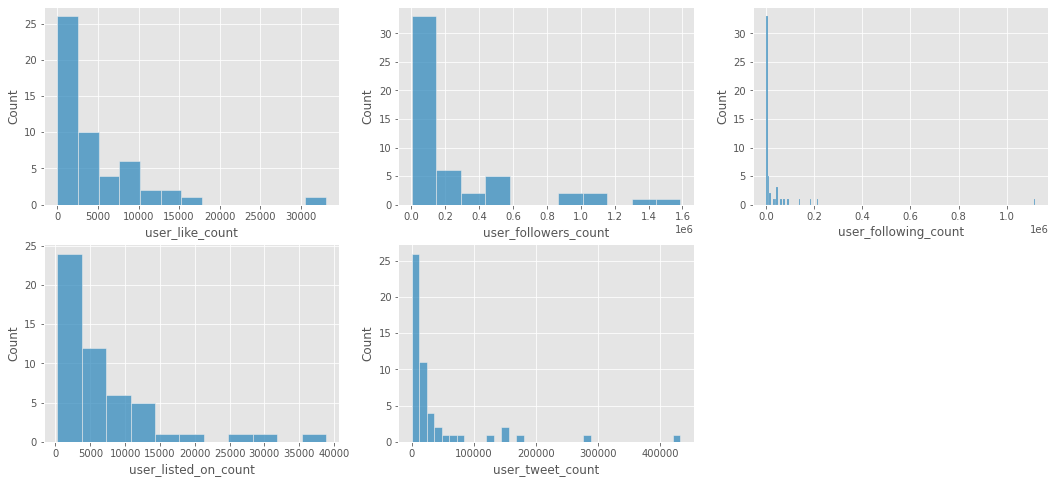

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

sns.histplot(users, x = 'user_like_count', ax = axs[0,0])
sns.histplot(users, x = 'user_followers_count', ax = axs[0,1])
sns.histplot(users, x = 'user_following_count', ax = axs[0,2])
sns.histplot(users, x = 'user_listed_on_count', ax = axs[1,0])
sns.histplot(users, x = 'user_tweet_count', ax = axs[1,1])
axs[1][2].set_visible(False)
plt.show()

### User Has
user_has_location  
user_has_url  
user_verified

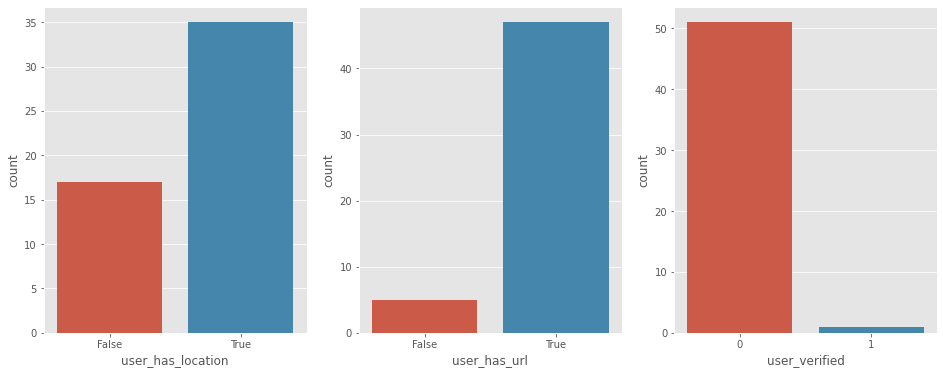

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

sns.countplot(x = 'user_has_location', data = users, ax = axs[0])
sns.countplot(x = 'user_has_url', data = users, ax = axs[1])
sns.countplot(x = 'user_verified', data = users, ax = axs[2])
plt.show()

### User Creation Date

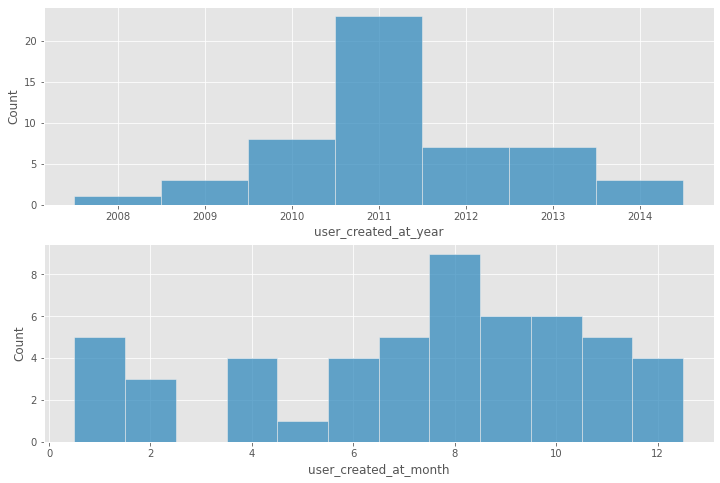

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(users, x = 'user_created_at_year', discrete = True, ax = axs[0])
sns.histplot(users, x = 'user_created_at_month', discrete = True, ax = axs[1])
plt.show()

## User Vectorized Descriptions

In [18]:
user_vectorized_descriptions.head()

,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,0.047779,...,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,0.007423,...,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,-0.006010,...,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,-0.037929,...,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,4,0.099192,-0.140809,-0.012423,-0.150097,-0.120169,0.054078,-0.384291,-0.269650,-0.046161,...,0.179307,-0.367725,-0.217667,-0.064391,0.163382,-0.020638,0.181554,-0.200262,-0.074513,0.037301


## User Vectorized Profile Images

In [19]:
user_vectorized_profile_images.head()

,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2038,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047
0,0,0.449126,0.000000,0.000000,0.0,0.006348,0.000000,0.059772,0.026143,0.013903,...,0.202886,0.000000,0.414033,0.000000,0.001876,0.000000,0.00000,0.000000,0.192305,0.000009
1,1,0.017050,0.009737,0.002633,0.0,0.000000,0.000000,1.184751,0.000000,0.000000,...,0.111723,0.086082,0.000000,0.000000,0.412172,0.000000,0.00000,0.254945,0.536927,0.460923
2,2,0.000000,0.068666,0.000000,0.0,0.000000,0.085349,0.349153,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.054352,0.000000,0.219981,0.00000,0.000000,0.150882,0.000000
3,3,0.000000,0.168951,0.118449,0.0,0.000000,0.000000,0.392767,0.000000,0.000000,...,0.000000,0.168835,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.424234,0.000000
4,4,0.286990,0.299091,0.138534,0.0,0.000000,0.000000,0.360286,0.042764,0.014573,...,0.163468,0.001998,0.224525,0.000000,0.235216,0.000000,0.01757,0.000000,0.059346,0.000000


# Preprocessing Train Data

## Missing Data

In [17]:
train_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           4285
virality                     0
dtype: int64

In [18]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

In [19]:
users.isnull().sum()

user_id                  0
user_like_count          0
user_followers_count     0
user_following_count     0
user_listed_on_count     0
user_has_location        0
user_tweet_count         0
user_has_url             0
user_verified            0
user_created_at_year     0
user_created_at_month    0
dtype: int64

## Categorical Variables

### Train Tweets

#### One-hot encoding

In [20]:
topic_ids = (
    train_tweets.tweet_topic_ids.str.strip('[]').str.split('\s*,\s*').explode().str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [21]:
year = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

#### Cyclical Encoding

In [22]:
hour_sin = np.sin(2 * np.pi * train_tweets['tweet_created_at_hour']/24.0)
hour_sin.name = 'hour_sin'
hour_cos = np.cos(2 * np.pi * train_tweets['tweet_created_at_hour']/24.0)
hour_cos.name = 'hour_cos'

In [23]:
# Join encoded data to train data.
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
               ]
encoded = [topic_ids, year, month, day, attachment, language, hour_sin, hour_cos]

train_tweets_final = train_tweets.drop(columns_drop, 1).join(encoded)
train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,...,language_22,language_23,language_24,language_25,language_27,language_28,language_29,language_30,hour_sin,hour_cos
0,34698,10,2.0,1.0,0.0,False,3,0,0,0,...,0,0,0,0,0,0,0,0,0.707107,0.707107
1,24644,4,0.0,1.0,0.0,False,3,0,1,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2,36321,54,2.0,3.0,0.0,True,1,0,2,0,...,0,0,0,0,0,0,0,0,-0.707107,-0.707107
3,2629,42,0.0,1.0,1.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819
4,28169,32,2.0,1.0,0.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819


### Users

#### One-hot encoding

In [24]:
year = pd.get_dummies(users.user_created_at_year, prefix='year')
month = pd.get_dummies(users.user_created_at_month , prefix='month')

In [25]:
# Join encoded data to train data.
columns_drop = [
                "user_created_at_year",
                "user_created_at_month",
               ]
dfs = [year, month]

users_final = users.drop(columns_drop, 1).join(dfs)
users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,year_2008,...,month_2,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1164,48720,70469,5956,True,14122,True,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,3914,85361,2171,5943,False,6957,False,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,8292,200944,1416,8379,True,83485,True,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,1770,15385,4572,1866,True,12265,True,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,15311,459083,1021,7368,False,121193,False,0,0,...,0,0,0,1,0,0,0,0,0,0


### Test Tweets

# Feature Engineering + Selection

## Train Tweets Media

In [26]:
print("train_tweets shape:", train_tweets.shape)
print("train_tweets_vectorized_media shape:", train_tweets_vectorized_media.shape)

# Match row number between train tweets and vectorized media
vectorized_media_df = pd.merge(train_tweets, train_tweets_vectorized_media, on='tweet_id', how='right')
# Drop extra columns
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

train_tweets shape: (29625, 14)
train_tweets_vectorized_media shape: (21010, 2050)


,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,1,00009_00008,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [27]:
# Set the target as well as dependent variables from image data.
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")] 

# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  127.84867623299999


Counter({True: 2046, False: 2})

In [28]:
media_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


## Train Tweets Text

In [29]:
print("train_tweets shape:", train_tweets.shape)
print("train_tweets_vectorized_text:", train_tweets_vectorized_media.shape)

# Match row number between train tweets and vectorized text
vectorized_text_df = pd.merge(train_tweets, train_tweets_vectorized_text, on='tweet_id', how='right')
# Drop extra columns
vectorized_text_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_text_df.head()

train_tweets shape: (29625, 14)
train_tweets_vectorized_text: (21010, 2050)


,virality,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,2,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,1,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,1,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [30]:
# Set the target as well as dependent variables from image data.
y = vectorized_text_df['virality']
x = vectorized_text_df.loc[:, train_tweets_vectorized_text.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  382.7465911080001


Counter({True: 674, False: 94})

In [31]:
text_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


## User Descriptions

In [32]:
# Find the median virality for each user to reduce features
average_virality_df = train_tweets.groupby('tweet_user_id').agg(pd.Series.median)['virality']

In [33]:
descriptions_df = pd.merge(average_virality_df, user_vectorized_descriptions, left_on='tweet_user_id', right_on='user_id', how='right')
descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,...,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,...,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,1,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,...,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,...,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3,4,0.099192,-0.140809,-0.012423,-0.150097,-0.120169,0.054078,-0.384291,-0.269650,...,0.179307,-0.367725,-0.217667,-0.064391,0.163382,-0.020638,0.181554,-0.200262,-0.074513,0.037301


In [34]:
# Set the target as well as dependent variables from image data.
y = descriptions_df['virality']
x = descriptions_df.loc[:, descriptions_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.017299320000006446


Counter({False: 768})

In [35]:
desc_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id
0,0
1,1
2,2
3,3
4,4


## User Profile Images

In [36]:
profile_images_df = pd.merge(average_virality_df, user_vectorized_profile_images, left_on='tweet_user_id', right_on='user_id', how='right')
profile_images_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_2038,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047
0,1,0,0.449126,0.000000,0.000000,0.0,0.006348,0.000000,0.059772,0.026143,...,0.202886,0.000000,0.414033,0.000000,0.001876,0.000000,0.00000,0.000000,0.192305,0.000009
1,2,1,0.017050,0.009737,0.002633,0.0,0.000000,0.000000,1.184751,0.000000,...,0.111723,0.086082,0.000000,0.000000,0.412172,0.000000,0.00000,0.254945,0.536927,0.460923
2,1,2,0.000000,0.068666,0.000000,0.0,0.000000,0.085349,0.349153,0.000000,...,0.000000,0.000000,0.000000,0.054352,0.000000,0.219981,0.00000,0.000000,0.150882,0.000000
3,1,3,0.000000,0.168951,0.118449,0.0,0.000000,0.000000,0.392767,0.000000,...,0.000000,0.168835,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.424234,0.000000
4,3,4,0.286990,0.299091,0.138534,0.0,0.000000,0.000000,0.360286,0.042764,...,0.163468,0.001998,0.224525,0.000000,0.235216,0.000000,0.01757,0.000000,0.059346,0.000000


In [37]:
# Set the target as well as dependent variables from image data.
y = profile_images_df['virality']
x = profile_images_df.loc[:, profile_images_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.03186161600001469


Counter({False: 2002, True: 46})

In [38]:
user_prof_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,...,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,...,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,...,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,...,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,...,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,...,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


In [39]:
print("Shape:")
print("train_tweets:", train_tweets_final.shape)
print("train_tweets_media:", train_tweets_media_final.shape) # join on tweet id
print("train_tweets_text:", train_tweets_text_final.shape) # join on tweet id
print("")
print("user", users_final.shape) 
print("user_description", user_descriptions_final.shape) # join on user id
print("user_profile", user_profile_images_final.shape) # join on user id

Shape:
train_tweets: (29625, 151)
train_tweets_media: (21010, 2048)
train_tweets_text: (29625, 675)

user (52, 27)
user_description (52, 1)
user_profile (52, 47)


In [40]:
# Group media by tweet_id (since there are multiple media id for a single tweet)
media_df = train_tweets_media_final.groupby('tweet_id').mean()

In [41]:
# tweets_vectorized_text and user_vectorized_profile_images has same column names. 
# rename columns in tweets_vectorized_text
cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,...,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [42]:
# Merge all tables on the column 'user_id' for user data and tweet_id for tweet data

# Join tweets data
tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# Join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# Join tweets data on train_tweets
tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id')

# Join with the users data
final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

final_df.shape

(29625, 2944)

# Preprocessing Test Data

## Test Tweets

In [43]:
test_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           1802
dtype: int64

In [44]:
test_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

In [45]:
topic_ids = (
    test_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [46]:
year = pd.get_dummies(test_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(test_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(test_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(test_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(test_tweets.tweet_language_id, prefix='language')

In [47]:
hour_sin = np.sin(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
hour_sin.name = 'hour_sin'
hour_cos = np.cos(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
hour_cos.name = 'hour_cos'

In [48]:
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
              ]
dfs = [
        topic_ids,
        year,
        month,
        day,
        attachment,
        language,
        hour_sin,
        hour_cos,
      ]

test_tweets_final = test_tweets.drop(columns_drop, 1).join(dfs)
test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,topic_id_0,topic_id_100,topic_id_101,topic_id_104,...,language_19,language_20,language_21,language_23,language_24,language_25,language_26,language_29,hour_sin,hour_cos
0,6238,13,5.0,2.0,0.0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,-8.660254e-01
1,37458,14,0.0,0.0,1.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.000000,-1.836970e-16
2,23968,50,0.0,1.0,0.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,5.000000e-01
3,24137,50,0.0,1.0,1.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.707107,7.071068e-01
4,8064,30,2.0,2.0,0.0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,-5.000000e-01


In [49]:
# columns missing in train from test
cols_test = set(test_tweets_final.columns) - set(train_tweets_final.columns)
cols_test

{'language_26', 'topic_id_117', 'topic_id_123', 'topic_id_38'}

In [50]:
for col in cols_test:
    final_df[col] = 0

In [51]:
# columns missing in test from train
cols_train = set(train_tweets_final.columns) - set(test_tweets_final.columns)
cols_train.remove('virality') # remove virality from columns to add to test
cols_train

{'language_14',
 'language_15',
 'language_16',
 'language_17',
 'language_22',
 'language_27',
 'language_28',
 'language_30',
 'topic_id_165'}

In [52]:
for col in cols_train:
    test_tweets_final[col] = 0

In [53]:
test_tweets_media_final = pd.concat([test_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
test_tweets_text_final = pd.concat([test_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)

media_df = test_tweets_media_final.groupby('tweet_id').mean()

cols = test_tweets_text_final.columns[test_tweets_text_final.columns.str.contains('feature_')]
test_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)

# Join tweets data
tweet_df = pd.merge(media_df, test_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# Join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# Join tweets data on train_tweets
tweet_df_final = pd.merge(test_tweets_final, tweet_df, on = 'tweet_id')

# Join with user data
p_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

p_final_df.shape

(12697, 2947)

In [54]:
final_df.shape # Has one more than test because of virality column

(29625, 2948)

# Build model

In [55]:
X = final_df.drop(['virality', 'tweet_user_id', 'tweet_id', 'user_id'], axis=1)
y = final_df['virality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (20737, 2944)
Test set shape  (8888, 2944)


## LGBM

In [56]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [57]:
# Prediction on the test dataset
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6643


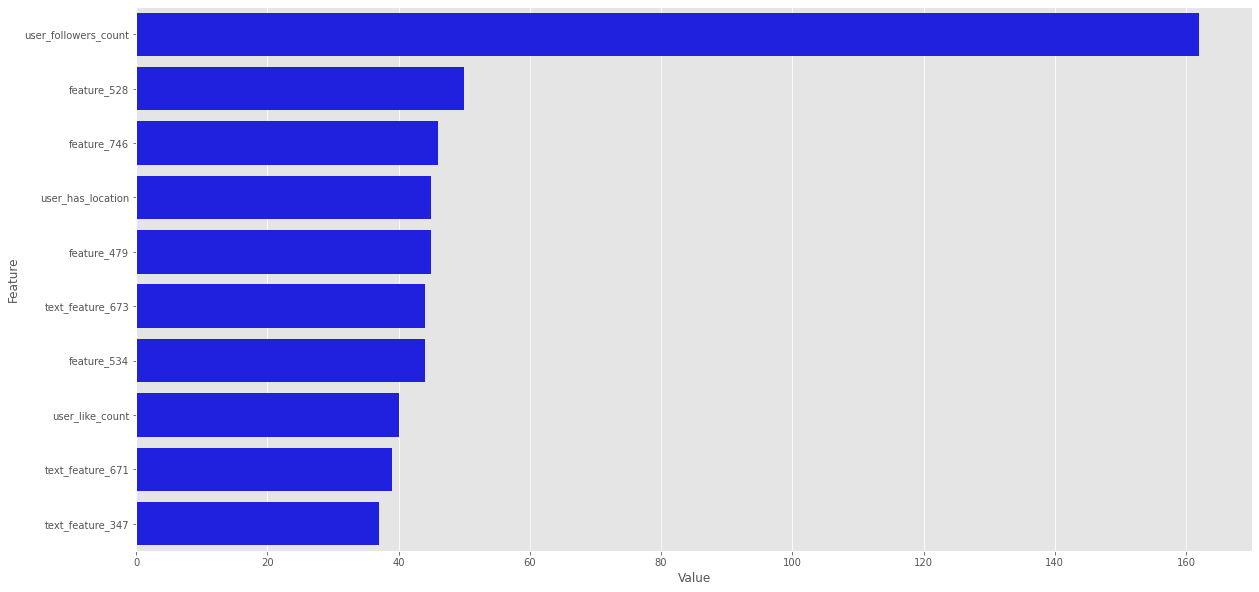

In [58]:
# Identify feature importance
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10], color='blue')
plt.show()

## KNeighbors Classifier

In [59]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [60]:
# Prediction on the test dataset
y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('KNeighborsClassifier Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

KNeighborsClassifier Model accuracy score: 0.6359


## Gradient Boosting Classifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
graident = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [71]:
# Prediction on the test dataset
y_pred = graident.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('XGBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

XGBoost Model accuracy score: 0.6634


# Fit model to Test data

In [72]:
X = p_final_df.drop(['tweet_user_id', 'tweet_id', 'user_id'], axis=1)

solution = XGB.predict(X)
solution_df = pd.concat([p_final_df[['tweet_id']], pd.DataFrame(solution, columns = ['virality'])], axis=1)
solution_df.head()

,tweet_id,virality
0,6238,2
1,6334,2
2,5822,3
3,6260,1
4,6162,1


## Download solutions as csv

In [ ]:
#solution_df.to_csv('solution.csv', index=False)